# 04 - Movement Decomposition and antecedents

This notebook illustrates not only the movement decomposition features of the `wmatarawnav` package, but also the necessary data preparation that takes place before the decomposition and the association of stop-related information that takes place after the decomposition. 

The movement decomposition is intended to support analyses of transit service improvements, but applications of the movement decomposition are not discussed here. These applications remain under development. 

The contents of this notebook include: 

1. Environment Setup
2. Walkthrough of Decomposition Code

    1. Summary of Read-in and Stop Indexing that Precedes decomposition
    2. Pre-Decomposition Cleaning
    3. Speed and Other Calculations 
    4. Movement Decomposition
    5. Relating Decomposition to Other Stop Locations
    
3. Summary of Decomposition Fields

# 1. Environment Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import shutil
import pyarrow as pa
import pyarrow.parquet as pq
from dotenv import dotenv_values

if os.getlogin() == "WylieTimmerman":
    # Working Paths
    # the following needed to run in vscode jupyter interpreter
    os.environ["GDAL_DATA"] = os.environ["CONDA_PREFIX"] + "\Library\share\gdal"
    path_working = r"C:\Users\WylieTimmerman\Documents\projects_local\WMATA_AVL_datamart"
    os.chdir(os.path.join(path_working))
    sys.path.append(r"C:\Users\WylieTimmerman\Documents\projects_local\WMATA_AVL_datamart")
    path_sp = r"C:\OD\Foursquare ITP\Projects - WMATA Datamart\Task 3 - Bus Priority"
    path_source_data = os.path.join(path_sp, "data", "00-Raw")
    path_processed_data = os.path.join(path_sp, "Data", "02-Processed")
    # Server credentials
    config = dotenv_values(os.path.join(path_working, '.env'))
    # other things for wylie's dev environment

import wmatarawnav as wr

analysis_route = ['43']
wmata_crs = 2248

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


# 2. Walkthrough of Decomposition Code

## 2.A Summary of Read-in and Stop Indexing that Precedes decomposition

rawnav data that is decomposed is first read into python using the process described in the first vignette, Intro to Rawnav Parsing. This process is likely to change as the Datamart develops, such that rawnav data would be read directly from a WMATA database. 

A sample of this raw data is shown below

In [2]:
rawnav_route = (
    pq.read_table(
        source=os.path.join(".", "data", "00-raw", "demo_data", "04_notebook_data", "rawnav.parquet"),
        use_pandas_metadata=True
    )
    .to_pandas()
    # Correcting for weirdness when writing to/ returning from parquet
    .assign(
        pattern=lambda x: x.pattern.astype('int32', errors="ignore")
    )
)

rawnav_route.head(6)

,filename,index_run_start,route,pattern,route_pattern,wday,start_date_time,end_date_time,index_loc,sec_past_st,odom_ft,door_state,row_before_apc,stop_window,veh_state,heading,lat,long,sat_cnt,blank
0,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2327.0,0.0,0.0,O,0.0,,S,107.0,38.931208,-77.03851,9.0,5.0
1,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2328.0,1.0,0.0,O,0.0,X-1,S,107.0,38.931208,-77.03851,9.0,1.0
2,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2329.0,1.0,0.0,O,1.0,E00,S,107.0,38.931208,-77.03851,9.0,1.0
3,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2331.0,46.0,0.0,C,0.0,,S,107.0,38.931208,-77.03851,9.0,1.0
4,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2332.0,62.0,0.0,O,1.0,,S,107.0,38.931208,-77.03851,9.0,1.0
5,rawnav02205171017.txt,2327.0,43,1,4301,Monday,2017-10-16 08:14:01,2017-10-16 08:42:10,2334.0,105.0,0.0,C,0.0,,S,107.0,38.931208,-77.03851,9.0,2.0




Next, stop locations for each route pattern are associated to rawnav data using the same process identified in the second vignette, Relate Rawnav to Other Sources. This process is also likely to change as the map matching process used in the Datamart project develops. However, the current process can also be continued with the use of connections to existing WMATA schedule databases.


In [3]:
stop_index = (
    pq.read_table(
            source=os.path.join(".", "data", "00-raw", "demo_data", "04_notebook_data", "stop_index.parquet"),
            use_pandas_metadata=True
        )
        .to_pandas()
        # Correcting for weirdness when writing to/ returning from parquet
        .assign(
            pattern=lambda x: x.pattern.astype('int32', errors="ignore")
        )

)

stop_index.head(6)

,index,route,pattern,direction,stop_id,stop_sequence,filename,index_run_start,index_loc,odom_ft_stop,sec_past_st,geo_description
0,0,43,1,SOUTH,1151,1,rawnav02205171017.txt,2327.0,2344.0,43.0,216.0,LAMONT ST NW + MT PLEASANT ST NW
1,1,43,1,SOUTH,1152,2,rawnav02205171017.txt,2327.0,2384.0,1136.0,259.0,MT PLEASANT ST NW + KENYON ST NW
2,2,43,1,SOUTH,1153,3,rawnav02205171017.txt,2327.0,2408.0,1918.0,359.0,MT PLEASANT ST NW + IRVING ST NW
3,3,43,1,SOUTH,1154,4,rawnav02205171017.txt,2327.0,2457.0,3493.0,451.0,MT PLEASANT ST NW + HARVARD ST NW
4,4,43,1,SOUTH,1155,5,rawnav02205171017.txt,2327.0,2507.0,4915.0,581.0,COLUMBIA RD NW + QUARRY RD NW
5,5,43,1,SOUTH,1156,6,rawnav02205171017.txt,2327.0,2541.0,6109.0,612.0,COLUMBIA RD NW + ONTARIO RD NW


## 2.B Pre-Decomposition Cleaning

Because the movement decomposition algorithm is sensitive to changes in speed and acceleration over intervals as short as one second, clean data is especially important before beginning the decomposition. Two cleaning steps take place to address odometer values that can result in noisy or inaccurate speed calculations. If these issues are unaddressed, rawnav data can briefly show infinite speed (non-zero distance traveled in zero seconds) or show noisy speed values (brief speed increases followed by equally sharp decreases in the next second). 

The cleaning steps are described in more detail below and in the function documentation itself.

The number of seconds after a trip instance (called a 'run' in previous documentation) begins is an essential element of rawnav data. Referred to in python code as `sec_past_st` or "seconds past start", it begins at 0 and increments in integer seconds until the end of the trip instance. At times, these second values will repeat, such that the `sec_past_st` value of, say, 30, might appear twice in a row. The reasons for this will not be described in detail here, but the duplicate time values typically occur when other trip tags appear in the data, such as APC tags or calibration tags. 

When these seconds values are repeated, other parts of the data may nevertheless change, such as the door state, the rawnav stop window identifier, or the odometer reading. (As an aside, based on this observation, it is believed that these integer seconds values are therefore rounded from a more precise recording of the time elapsed, rather than a regular interval at which data is recorded). If the odometer increases between two pings but the amount of time elapsed does not change, then a speed calculation would show the bus traveling at an infinite speed between the two points. While these infinite speed values could simply be removed (as was done in earlier code for the Queue Jump study), addressing the problem closer to its root provides some benefits. In particular, converting these integer seconds values into timestamp values allows for the use of additional timeseries-oriented functions in Python. Many of these functions do not accept repeated timestamp values, so it is helpful to resolve the issue.

A sample of rawnav data for a second with repeated `sec_past_st` values is shown below.

In [4]:
(
    rawnav_route
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st > 231 & sec_past_st < 238')
    .filter(['index_loc','sec_past_st','odom_ft','stop_window'], axis = "columns")
)

,index_loc,sec_past_st,odom_ft,stop_window
30,2361.0,233.0,536.0,
31,2362.0,233.0,590.0,X-1
32,2363.0,234.0,603.0,
33,2364.0,235.0,671.0,
34,2365.0,235.0,731.0,
35,2366.0,237.0,790.0,
36,2367.0,237.0,798.0,E02


To address the challenges above, the first step in pre-decomposition cleaning is to aggregate data for repeated seconds values such that each second appears only once. For most variables, the last value observed is recorded, such that if a door open and then a door close value are seen in the same second, only the latter value is maintained. This is based on the assumption that most state changes that last less than a second are not important, and are available in other parts of the Datamart if relevant. For the odometer reading (`odom_ft` in the python code), the minimum, maximum, and mean reading within the second are recorded in new columns, with the mean value used to represent distance traveled at that second. Various other approaches to aggregating the odometer reading at this point were explored, including interpolation and using the last odometer reading, but the mean proved to be a simple approach with reasonable results for speed calculations. There are other, minor exceptions to the aggregation of certain variables that are documented within the functions themselves. 

This aggregation is performed with the agg_sec() function, which can readily accept other columns that are introduced to rawnav data as Datamart processing code evolves. The result of the agg_sec() function is rawnav data with no duplicated seconds values and several additional columns that are the product of the aggregation process. A sample of rows is shown below.

In [5]:
rawnav_route_1 = wr.agg_sec(rawnav_route)

(
    rawnav_route_1
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st > 231 & sec_past_st < 238')
    .filter(['index_loc','sec_past_st','odom_ft','odom_ft_min','odom_ft_max', 'odom_ft_mean', 'stop_window'], axis = "columns")
)


,index_loc,sec_past_st,odom_ft,odom_ft_min,odom_ft_max,odom_ft_mean
5,2362.0,233.0,563.0,536.0,590.0,563.0
32,2363.0,234.0,603.0,NaN,NaN,NaN
6,2365.0,235.0,701.0,671.0,731.0,701.0
7,2367.0,237.0,794.0,790.0,798.0,794.0


## 2.C Speed and Other Calculations 

With more consistent odometer and time data prepared, vehicle speed and acceleration can be calculated. While these calculations are straightforward, there remains some 'noise' to the calculated speed values. This is believed to be the result of both normal variation in speed and the fact that odometer and time values that have been rounded to the nearest integer. Short, sharp changes in speed can result in changes in acceleration that can affect the decomposition algorithm below, so additional smoothing is applied to speed values, and rolling values are calculated based on these smoothed values. The subsections below provide more detail.

### 2.C.1 Calculating Speed

The speed at a particular ping is calculated as the difference in odometer reading between that ping and the next ping divided by the difference in time elapsed between that ping and the next ping. The variable is called `fps_next`. Instantaneous speed at a ping is calculated relative to the next ping is used instead of the previous ping because the resulting speeds based on the next ping better correlate with other information about vehicle state at a ping (e.g., where the door is open, we expect recorded speed to be 0 or near 0, and this is more often the case when speed is calculated from that ping relative to the next ping).

In [6]:
rawnav_route_2 = wr.calc_speed(rawnav_route_1)

(
    rawnav_route_2
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st > 231 & sec_past_st < 238')
    .filter(['index_loc','sec_past_st','odom_ft','fps_next'], axis = "columns")
)


,index_loc,sec_past_st,odom_ft,fps_next
5,2362.0,233.0,563.0,40.0
32,2363.0,234.0,603.0,98.0
6,2365.0,235.0,701.0,46.5
7,2367.0,237.0,794.0,45.0


As shown above, at times, calculated speed values can be very high relative to speeds even a second before and after. The next step in data pre-processing addresses this challenge.

### 2.C.2 Smoothing Speed Values

The `fps_next` speed value is smoothed using the Savitzky-Golay filter, an easy-to-implement low-pass filter. This filter tends to preserve the shape of speed curves well while being easy to implement. The key inputs to the filter are the type of polynomial (we use a 3rd degree polynomial) and the number of seconds over which the filter applies (we use 21 seconds). Both of these are semi-arbitrary choices based on experimentation during exploratory analysis. The use of the Savitzy-Golay filter requires some temporary transformations of rawnav data that are described in more detail in the Python function documentation. Note that even though speed values are smoothed, the underlying odometer values are not changed.

A Kalman Filter may be the more appropriate choice for smoothing data that can be the product of sensor inaccuracy. However, implementing such a filter would require more development effort and has not been pursued to date.

The smoothing process produces the smoothed value `fps_next_sm`, but the original value `fps_next` still has a role to play in the decomposition. Selected values are shown below

In [7]:
rawnav_route_3 = wr.smooth_speed(rawnav_route_2)

(
    rawnav_route_3
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st > 224 & sec_past_st < 237')
    .assign(
        odom_ft = lambda x: x.odom_ft.round(2),
        fps_next = lambda x: x.fps_next.round(2),
        fps_next_sm = lambda x: x.fps_next_sm.round(2)
    )
    .filter(['index_loc','sec_past_st','odom_ft','fps_next', 'fps_next_sm'], axis = "columns")
)


,index_loc,sec_past_st,odom_ft,fps_next,fps_next_sm
18,2353.0,225.0,167.50,42.50,33.28
19,2354.0,226.0,210.00,21.00,39.46
20,2355.0,228.0,252.00,49.00,48.81
21,2356.0,229.0,301.00,85.33,51.77
22,2359.0,230.0,386.33,83.67,55.45
23,2360.0,231.0,470.00,46.50,59.92
24,2362.0,233.0,563.00,40.00,60.20
25,2363.0,234.0,603.00,98.00,57.89
26,2365.0,235.0,701.00,46.50,54.66


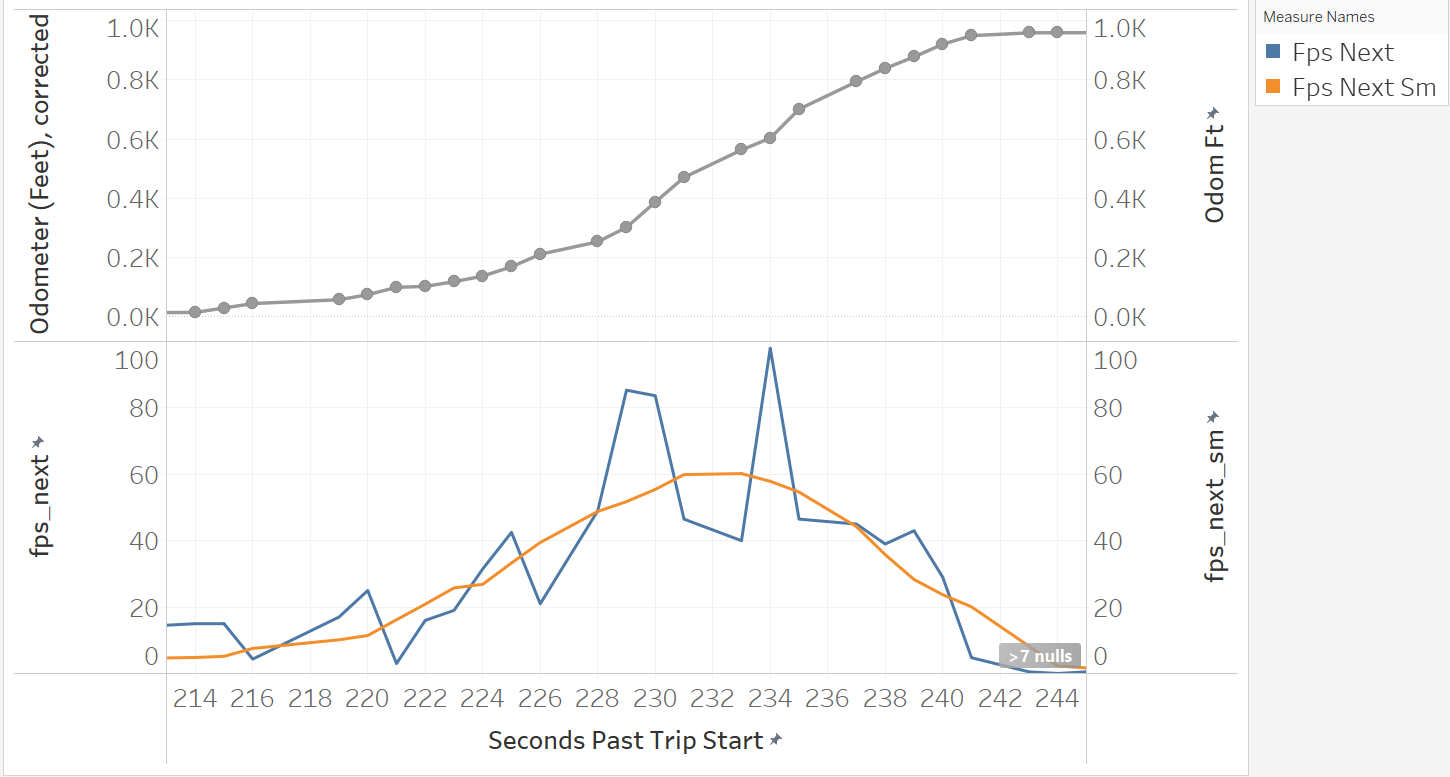

### 2.C.3 Calculating Rolling Values and Derivatives of Speed

Based on the smoothed speed values, acceleration is calculated. The derivative of acceleration--'jerk'--was briefly investigated for use in the movement decomposition. Though it appeared ultimately unnecessary for decomposition, jerk is still calculated in the Python code.

Rolling averages based on smoothed values are then calculated for windows of three and nine seconds for speed, acceleration, and jerk. While smoothing functions already transform the data in ways similar to a rolling average, a separate calculation of these rolling averages is used to identify meaningful changes in the vehicle's state as described in the next section. While several variations of these rolling averages are calculated--3-second windows, 9-second windows, and so forth--of these rolling values, only the 9-second rolling average of acceleration is used in decomposition. Through exploratory analysis, this window of time effectively captured changes in the vehicle's acceleration without being overly sensitive to minor upticks or downticks in acceleration. Future work on the decomposition algorithm might instead apply a differently sized window or apply a smoothing filter instead.

In [8]:
rawnav_route_4 = wr.calc_rolling(rawnav_route_3)
(
    rawnav_route_4
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st > 224 & sec_past_st < 237')
    .assign(
        odom_ft = lambda x: x.odom_ft.round(2),
        fps_next_sm = lambda x: x.fps_next_sm.round(2),
        accel_next = lambda x: x.accel_next.round(2),
        accel9 = lambda x: x.accel9.round(2),
    )
    .filter(['index_loc','sec_past_st','odom_ft','fps_next_sm', 'accel_next', 'accel9'], axis = "columns")
)


,index_loc,sec_past_st,odom_ft,fps_next_sm,accel_next,accel9
18,2353.0,225.0,167.50,33.28,6.42,4.42
19,2354.0,226.0,210.00,39.46,6.18,4.29
20,2355.0,228.0,252.00,48.81,4.40,4.17
21,2356.0,229.0,301.00,51.77,2.96,3.95
22,2359.0,230.0,386.33,55.45,3.68,2.71
23,2360.0,231.0,470.00,59.92,4.47,1.36
24,2362.0,233.0,563.00,60.20,-0.42,-0.22
25,2363.0,234.0,603.00,57.89,-2.32,-1.85
26,2365.0,235.0,701.00,54.66,-3.23,-3.44


An additional example is shown in the chart

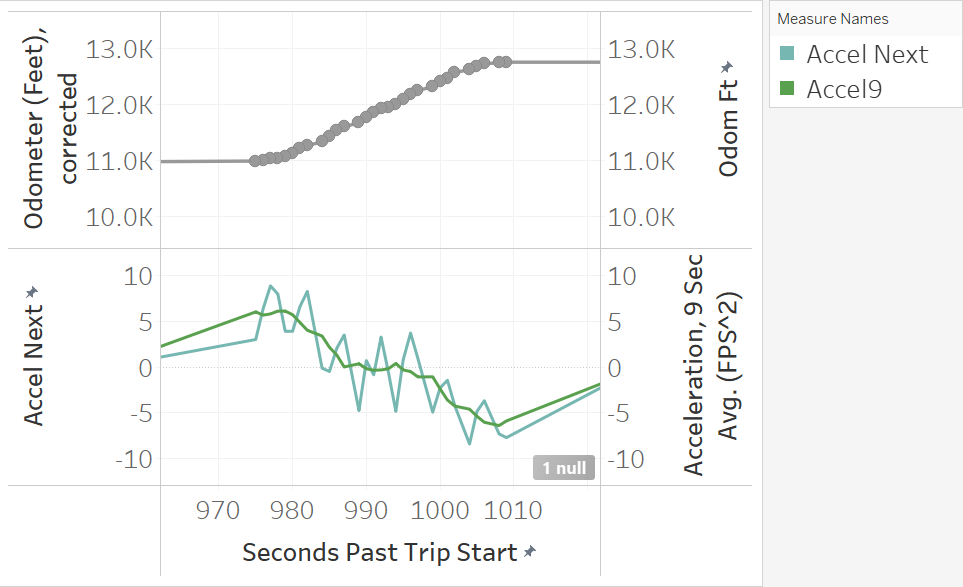

### Conclusion

Overall, the process of aggregating, cleaning, smoothing, and calculating rolling values of speed data may appear overcomplicated. Because the movement decomposition was developed iteratively, a different solution might be able to reach this result in a more straightforward manner, particularly through the use of a more sophisticated smoothing solution like the Kalman Filter. For now, each of the steps above fills a logical role in the preparation of rawnav data for decomposition.

## 2.D Movement Decomposition

The movement decomposition takes place at two levels of detail:

- The "basic" decomposition, which decomposes time in a trip instance into acceleration, steady state, deceleration, stopped time, and 'other delay'. 
- The stop decomposition, which further decomposes stopped time, especially in cases where passengers are served. 

In the process of performing these decompositions, other fields that may support analysis of bus performance are also calculated, especially regarding vehicle heading. As these features are further developed, they will be expanded upon in this section.

The basic and stop decomposition steps are described below.

### 2.D.1 Basic Decomposition

The basic decomposition follows a simple logic that relies on three key parameters:

- the maximum speed of a "stopped" vehicle (`stopped_fps`)
- the maximum speed of a slow vehicle (`slow_fps`)
- the range of acceleration values allowable in a steady state (`steady_accel_thresh`)

The application of these parameters to generate the movement decomposition is described in the steps below.

1. A vehicle is stopped when its unsmoothed speed value `fps_next` drops below the `stopped_fps` threshold. The unsmoothed speed value is used because this avoids cases where smoothing or rolling averages would make the vehicle appear to be moving when it is in fact stopped. The `stopped_fps` defaults to 3 feet per second (~2 miles per hour) and not zero due to characteristics of how rawnav data are recorded. Vehicles tend to stop generating new rawnav pings once stopped, but once moving again, will generate pings. As a result, over the long gap between a ping when the vehicle stops and the next ping recorded, a small, non-zero speed will usually be seen over that interval.
2. A vehicle is in steady state under two conditions: 
 - Its average, smoothed speed exceeds a minimum speed of 10 mph (or 14.67 feet per second) (the default `slow_fps`).
 - Its average acceleration over nine seconds does not exceed +/- 2 fps squared (the default `steady_accel_thresh`).
The use of rolling averages on smoothed speed values is used to avoid cases where steady state is entered or exited frequently based on brief changes in the vehicle's movement.
3. While moving, a vehicle is in a deceleration phase between its last ping in steady state to the next time it stops. Similarly, a vehicle is in an acceleration phase between being stopped and the first steady state ping recorded. 
4. During steady state, a vehicle may at times accelerate or decelerate beyond the acceleration threshold or decrease in speed below the slow vehicle threshold without stopping. This state is identified as "other delay". Reasons for and interpretation of other delay can vary and are not elaborated on here. In some cases, if a vehicle never exceeds the speed of a slow vehicle while moving between stops, it remains in the state of 'other delay' for the entire segment.

In [9]:
rawnav_route_5 = (
    wr.decompose_mov(
        rawnav_route_4,
        stopped_fps=3, 
        slow_fps=14.67, # 10mph, in fps
        steady_accel_thresh=2  
    )
)

An example is shown in the table below

In [10]:
(
    rawnav_route_5
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st >= 1084 & sec_past_st <= 1126')
    .assign(
    )
    .filter(['sec_past_st','odom_ft','fps_next','fps_next_sm', 'accel9', 'basic_decomp'], axis = "columns")
)

,sec_past_st,odom_ft,fps_next,fps_next_sm,accel9,basic_decomp
327,1084.0,13537.000000,0.619048,9.544105,-4.020089,stopped
328,1105.0,13550.000000,6.000000,9.244688,5.043756,accel
329,1108.0,13568.000000,29.500000,22.648033,5.799533,accel
330,1109.0,13597.500000,40.500000,26.461869,5.395851,accel
331,1110.0,13638.000000,42.000000,33.045518,5.025176,accel
332,1111.0,13680.000000,22.500000,40.328266,4.501383,accel
333,1113.0,13725.000000,74.000000,49.425116,3.399341,accel
334,1114.0,13799.000000,82.000000,52.894702,2.258382,accel
335,1115.0,13881.000000,29.500000,54.253324,0.729954,steady
336,1117.0,13940.000000,83.500000,52.174322,-1.406570,steady


These thresholds are illustrated in the screenshot below using a different set of rawnav data as an example.

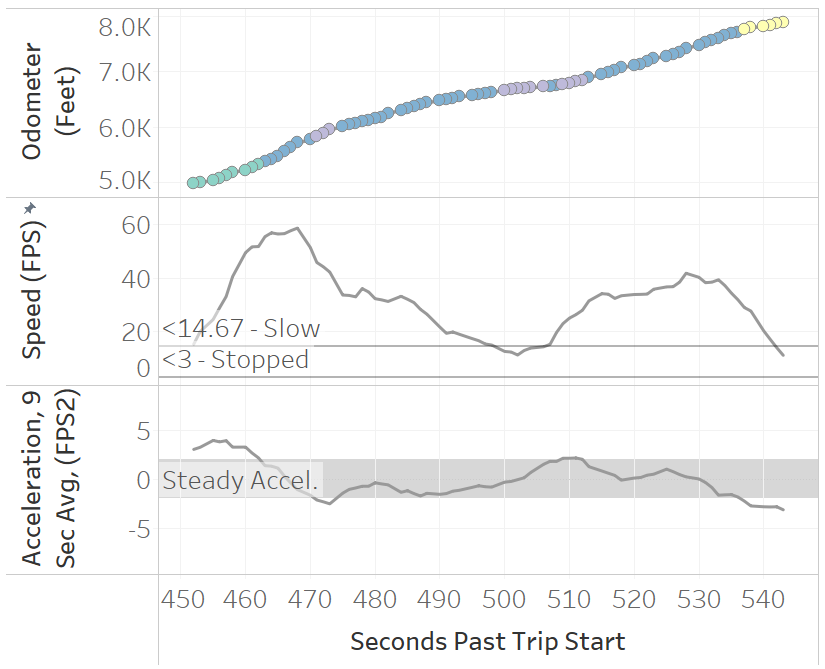

### 2.D.2 Stop Decomposition

#### Collapsing Stop Activity 

At near-side bus stops, a vehicle will often serve passengers, move forward slightly to the intersection stop bar, and then stop again while waiting for the signal to change. In the basic decomposition framework described above, this would appear as "stopped" -> "other_delay" -> "stopped", because vehicles will rarely exceed 10 mph and have near-zero acceleration while making these brief movements between being stopped.

Before stop decomposition occurs, this activity around a stop is collapsed into a single group of "stopped" activity at the basic level of the decomposition, which may in fact include vehicle movement! This process of collapsing occurs under specific conditions described in more detail in the Python code. The small movements around a stop are further decomposed in the Stop Decomposition described below.

#### Characteristics When Stopped

A vehicle's activity in these stop groups is characterized on several dimensions:

- Door case (same for all pings in a stop group): did the doors open (`doors`) or did they remain shut (`nodoors`)?
- Vehicle state: is the vehicle stopped (`S`) with `fps_next` less than `stopped_fps`, or is the vehicle moving (`M`)? Note that while the vehicle state is a variable within the original rawnav data, it is recalculated here. 
- Door state: are doors open (`O`) or closed (`C`)? This variable is sourced directly from the original rawnav data.
- Order relative to first door open event in the stop group: Is this ping:
    - Before the first door open (`pre`)
    - the first door open event (`at`)
    - after the first door open (`post`)
    - not in a stop group with a door open even (`na`)

These characteristics are combined into a single field `stop_decomp` that can be used to understand changes in vehicle behavior around a stop, such as the amount of time a vehicle spends stopped after its doors have closed and it is no longer serving passengers.

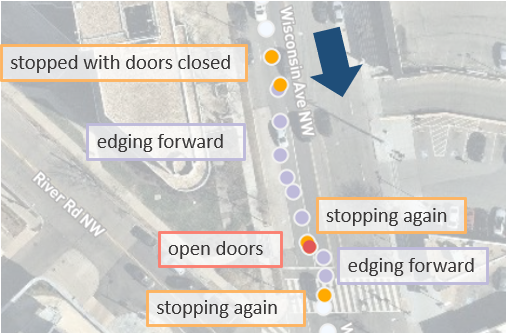

An example is shown below for a different set of rawnav data. In this example, the following takes place in the group of stop activity:

- The vehicle stops and its doors are closed (doors_pre_C_S)
- It opens its doors (doors_at_O_S)
- It closes its doors (doors_post_C_S)
- It moves forward slightly (doors_post_C_M)
- It stops again (doors_post_C_S)
- It moves forward slightly again (doors_post_C_M)
- It stops again (doors_post_C_S)


In [11]:
(
    rawnav_route_5
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st >= 610 & sec_past_st <= 705')
    .assign(
    )
    .filter(['sec_past_st','odom_ft','basic_decomp', 'door_case', 'relative_to_firstdoor', 'door_state', 'veh_state_calc', 'stop_decomp'], axis = "columns")
)

,sec_past_st,odom_ft,basic_decomp,door_case,relative_to_firstdoor,door_state,veh_state_calc,stop_decomp
156,610.0,6069.0,decel,<NA>,<NA>,C,M,<NA>
157,611.0,6099.0,decel,<NA>,<NA>,C,M,<NA>
158,612.0,6109.0,stopped,doors,pre,C,S,doors_pre_C_S
159,613.0,6110.0,stopped,doors,at,O,S,doors_at_O_S
160,614.0,6110.0,stopped,doors,at,O,S,doors_at_O_S
161,642.0,6110.0,stopped,doors,post,C,S,doors_post_C_S
162,651.0,6120.0,stopped,doors,post,C,M,doors_post_C_M
163,654.0,6130.0,stopped,doors,post,C,S,doors_post_C_S
164,660.0,6145.0,stopped,doors,post,C,M,doors_post_C_M
165,661.0,6155.0,stopped,doors,post,C,S,doors_post_C_S


Additional characteristics assigned to pings at a stop are described in subsequent sections. For now, a door state of 'open' is implicitly treated as though passengers were served. This is not necessarily the case, as can been confirmed by common experiences on a bus and by the absence of APC tags on some door open events in the data. 

Note that to this point, there is no assertion that door open events occur at bus stops or that other stopping events are related to intersections. That additional inference takes place in the following step when the decomposition is compared to data sources external to rawnav.

## 2.E Relating Decomposition to Other Stop Locations

Rawnav data includes no consistent stop identifier, such that an analyst could readily filter rawnav data to a particular stop segment or corridor across routes. After the groups of stop activity have been identified in previous decomposition steps, WMATA stop IDs are associated to these groups using WMATA schedule data and the indexing process described in the second vignette. These permit more user friendly analysis of rawnav data.

### 2.E.1 Matching Stops

The decomposition method used in the Queue Jump study (described in the third vignette) identified stop areas +/- 150 feet from known stop locations. In the movement decomposition approach, the known stop locations are used only to add identifiers to groups of stop activity. Because buses may stop at slightly different locations than known stop locations, matching logic is used to associate groups of stop-related activity with nearby stop_ids. Several rounds of matching are performed to address cases where stop activity falls between multiple, closely spaced stop locations or where multiple, distinct groups of stop activity lie near the same stop location. 

When matching a known stop location to a group of stop activity, the code looks for the cases below in order. Once one of these cases is satisfied for a known stop location, that stop ID will not be associated with any other stop activity groups.

   1. door open cases within 100 feet of the known stop location. 
   2. stop groups that had a door open within 100 feet of the known stop location. This is a slightly broader definition of the above that also looks for other related pings around the door open, such as when the bus serves a stop and then edges towards the intersection and stops again. 
   3. door closed cases within 100 feet of the known stop location.
    
If there is no stop activity within range of the known stop location, the rawnav ping closest to the stop is associated to the stop_id and a passup is noted. Additional checks are performed to ensure that no stop_id is matched twice and that no stop_id is matched to more than one cluster of stop activity. If a vehicle has deviated from the typical route pattern and is making stops at other locations, these stop IDs will not be associated to the trip instance, even if door open events occur.

In [12]:
rawnav_route_6 = wr.match_stops(rawnav_route_5, stop_index)

An example is shown below, illustrating how the group of stop-related activity in rawnav data (shown in the columns basic_decomp and stop_decomp) may not fall directly next to the known stop location (flagged in column stop_id_loc). Through this process, the stop_id_group column is created that associates the known stop location with nearby stop-related activity. 

In [13]:
(
    rawnav_route_6
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st >= 1005 & sec_past_st <= 1059')
    .assign(
    )
    .filter(['sec_past_st','odom_ft','basic_decomp','stop_decomp', 'stop_id_loc','stop_id_group'], axis = "columns")
)

,sec_past_st,odom_ft,basic_decomp,stop_decomp,stop_id_loc,stop_id_group
299,1005.0,12680.0,decel,<NA>,1160.0,NaN
300,1006.0,12724.0,decel,<NA>,NaN,NaN
301,1008.0,12742.0,decel,<NA>,NaN,NaN
302,1009.0,12751.0,stopped,doors_at_O_S,NaN,1160.0
303,1030.0,12751.0,stopped,doors_post_C_M,NaN,1160.0
304,1034.0,12766.0,stopped,doors_post_C_M,NaN,1160.0
305,1035.0,12784.0,stopped,doors_post_C_M,NaN,1160.0
306,1036.0,12803.0,stopped,doors_post_C_M,NaN,1160.0
307,1037.0,12816.0,stopped,doors_post_C_M,NaN,1160.0
308,1039.0,12826.0,stopped,doors_post_C_S,NaN,1160.0


### 2.E.2 Creating Stop Segments

A stop segment field is created based on the groups of stop-related activity that have been created above. Creating stop segments based on these identified stop groups, rather than known stop locations alone, has the benefit of more clearly separating out stopped time from in-motion time when conducting stop-to-stop travel time analyses.

At each stop, the column `trip_seg` takes only the stop_id_group value. Between stop activity, `trip_seg` is a string that collapses the previous and next stop, as in "25698_23697". Travel between the start of the trip instance and the first stop is identified as "tripstart_[first matched stop ID]", while travel after the last stop and to the end of the trip instance is identified as "[last matched stop ID]_tripend". At this time, other fields that associate acceleration from and deceleration to bus stops are also created.

In [14]:
rawnav_route_7 = wr.create_stop_segs(rawnav_route_6)

In [15]:
(
    rawnav_route_7
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st >= 1600')
    .assign(
    )
    .filter(['sec_past_st','odom_ft','basic_decomp','stop_id_loc','trip_seg'], axis = "columns")
)

,sec_past_st,odom_ft,basic_decomp,stop_id_loc,trip_seg
544,1600.0,23202.000000,decel,NaN,1166_1167
545,1601.0,23243.000000,decel,NaN,1166_1167
546,1603.0,23275.000000,decel,1167.0,1166_1167
547,1604.0,23302.500000,decel,NaN,1166_1167
548,1605.0,23310.000000,stopped,NaN,1167
549,1624.0,23310.000000,stopped,NaN,1167
550,1626.0,23331.000000,stopped,NaN,1167
551,1628.0,23348.000000,stopped,NaN,1167
552,1629.0,23367.000000,stopped,NaN,1167
553,1630.0,23395.000000,stopped,NaN,1167


### 2.E.3 Trimming the Beginning and End of Trips

Trip instances begin and end based on tags found in rawnav data. These changes in the vehicle's state are triggered by the operator, and operator behavior may not be consistent across trip instances. As a result, some trip instances will fail to 'close out' and may be excessively long. The python code will trim out pings from trip instances that fall before the first matched stop and after the last stop. In this way, visualization and analysis of trip instances can be more readily performed.

In [16]:
rawnav_route_8 = (
    rawnav_route_7
    .sort_values(['filename','index_run_start','index_loc'])
    .groupby(['filename', 'index_run_start'])
    .apply(lambda x: wr.trim_ends(x))
    .reset_index(drop=True)
)

(
    rawnav_route_8
    .query('filename == "rawnav02205171017.txt" & index_run_start == 2327')
    .query('sec_past_st >= 1600')
    .assign(
    )
    .filter(['sec_past_st','odom_ft','basic_decomp','stop_id_loc','trip_seg'], axis = "columns")
)

,sec_past_st,odom_ft,basic_decomp,stop_id_loc,trip_seg
544,1600.0,23202.0,decel,NaN,1166_1167
545,1601.0,23243.0,decel,NaN,1166_1167
546,1603.0,23275.0,decel,1167.0,1166_1167
547,1604.0,23302.5,decel,NaN,1166_1167
548,1605.0,23310.0,stopped,NaN,1167
549,1624.0,23310.0,stopped,NaN,1167
550,1626.0,23331.0,stopped,NaN,1167
551,1628.0,23348.0,stopped,NaN,1167
552,1629.0,23367.0,stopped,NaN,1167
553,1630.0,23395.0,stopped,NaN,1167


### 2.E.4 Odometer Alignments / Resets

Even after trip instances are trimmed, these instances will have a different odometer reading at the same point along the route's alignment. To date, several strategies have been attempted to realign odometer readings across trip instances so that they match at the same points on the route's path. One approach currently developed in the Python code--but not used yet in practice--resets all odometer readings and `sec_past_st` vaues to 0 at the second stop (or nth stop, as the user desires) along each pattern. Once map matching processes are further developed, this issue is likely to become significantly easier to address. 

# 3. Summary of Decomposition Fields



The fields generated by the pre-decomposition cleaning, speed calculations, decomposition, and stop matching are summarized in the tables below. Many of these are likely to change as the ETL of rawnav data matures and as the decomposition continues to evolve.

In the table below, the field types shown are the ideal type for the field, but may not be what are used within the Python code. For instance, there are some fields that are described as integer, even though they are stored and handled as float64 variables within Python. The coercion to float64 in Python is done because some Python integer types cannot accept null values and some earlier versions of the Parquet storage specification would coerce integers to floats. In a Datamart environment, these types may change again. Other fields may begin as integer but be transformed into float values during interpolation, such as for odom_ft.

First, fields that are sourced directly from rawnav data or generated during the Python-based parsing process:

In [17]:
fields_basic = pd.read_csv(os.path.join(".", "data", "00-raw", "demo_data", "04_notebook_data", "fieldlist_basic.csv"))
#TODO: create a csv in the style we want, add to version control, then read-in here.

fields_basic.drop(['sort'], axis = "columns")

,fieldname,source,type,nullable?,note
0,filename,python rawnav parser,string,no,NaN
1,index_run_start,python rawnav parser,int,no,NaN
2,route_pattern,python rawnav parser,string,no,NaN
3,pattern,python rawnav parser,int,no,NaN
4,index_run_end,python rawnav parser,int,no,NaN
5,route,python rawnav parser,string,no,NaN
6,wday,python rawnav parser,string,no,NaN
7,start_date_time,python rawnav parser,datetime,no,NaN
8,end_date_time,python rawnav parser,datetime,no,NaN
9,index_loc,python rawnav parser,int,no,NaN


These are the fields created during the processes shown in this notebook.

In [18]:
fields_added = pd.read_csv(os.path.join(".", "data", "00-raw", "demo_data", "04_notebook_data", "fieldlist_added.csv"))
#TODO: create a csv in the style we want, add to version control, then read-in here.

fields_added.drop(['sort'], axis = "columns")

,fieldname,source,description,type,nullable?,null when,"example values\n (comma separated, ... indicates other values possible)"
0,collapsed_rows,aggregation on repeated seconds,"At a sec_past_st value that is created by collapsing several records, this is the number of records that were collapsed. 1 otherwise.",int,no,NaN,"1, 2, 3, ..."
1,odom_ft_min,aggregation on repeated seconds,the minimum odometer reading where there were two observations at the same second. Used for clean up of interpolated values.,int,yes,NA for all pings that were not aggregated on a repeated sec_past_st value,"55, 120, ..."
2,odom_ft_max,aggregation on repeated seconds,the minimum odometer reading where there were two observations at the same second. Used for clean up of interpolated values.,int,yes,NA for all pings that were not aggregated on a repeated sec_past_st value,"60, 123, ..."
3,stop_window_e,aggregation on repeated seconds,"column that takes the E-** value from the stop_window field. This is done to prevent conflicts where the E-** and X-1 indicators appear in the same second. This may not strictly be necessary, but is a bit of future proofing in case the stop_window indicators become relevant again. If there were hypothetically multiple E-** indicators in the same second, they are joined by a comma in this field.",string,yes,"NA for all pings that did not have a stop_window identifier for a stop that included ""E-""","E-1, E-2, ..."
4,stop_window_x,aggregation on repeated seconds,"column that takes the X-1 value from the stop_window field. This is\ndone to prevent conflicts where the E-** and X-1 indicators appear in the same second. This may not strictly be necessary, but is a bit of future proofing in case the stop_window indicators become relevant again. If there were hypothetically multiple E-** indicators in the same second, they are joined by a comma in this field.",string,yes,NA for all pings that did not have a stop_window identifier for a stop equal to X-1,X-1
5,blank,aggregation on repeated seconds,"unknown column, collapsed using commas into a string during the aggregation process",string,no,NaN,"""0"", ""1"",""2"",..."
6,veh_state_all,aggregation on repeated seconds,"Unique values of vehicle state where there were two observations at \nthe same second. Vehicle state as sourced from the rawnav data itself isn't used in decomposition code, but we avoid throwing values out here.",string,no,NaN,"S, M"
7,odom_ft_next,speed calculations,the next odometer reading after the current ping.,float,no,NaN,"58.5, 65"
8,odom_ft_marg,speed calculations,the marignal difference in odometer feet between the current ping and the next ping,float,no,NaN,"7.5, 10"
9,sec_past_st_next,speed calculations,the next seconds past start reading after the current ping,int,no,NaN,"10, 11"
